# Topic modeling with NMF

With clustering, we can put documents into groups according to what they are about. This, in a sense, allows us to discover topics in the text. But that sort of analysis assumes that a topic can comprise only one topic. It would be better if we could allow for the fact that an individual might be better understood as comprised of multiple topics.

This is what topic modeling does. Like clustering, it is unsupervised. We just feed in the text, and topics come out.

There are some difficulties however. 

* Topic modeling algorithms have many parameters that we can adjust. This includes the number of topics.
* Some of the algorithms give different results each time you run them, even with the same parameters.
* The results aren't always easy to interpret.

The inputs:

* A document x term matrix. (A table with each vectorized document in a row)

The outpus:

* A list of topics, each represented by a weighting for each word in the vocabulary
* A analysis of the documents that gives the weight of each topic in the documents.

Also:

* A model that can be used to analyze new documents in terms of the model

## NMF (Non-negative Matrix Factorization) 

We are going to start with one algorithm that can be used for topic modeling NMF

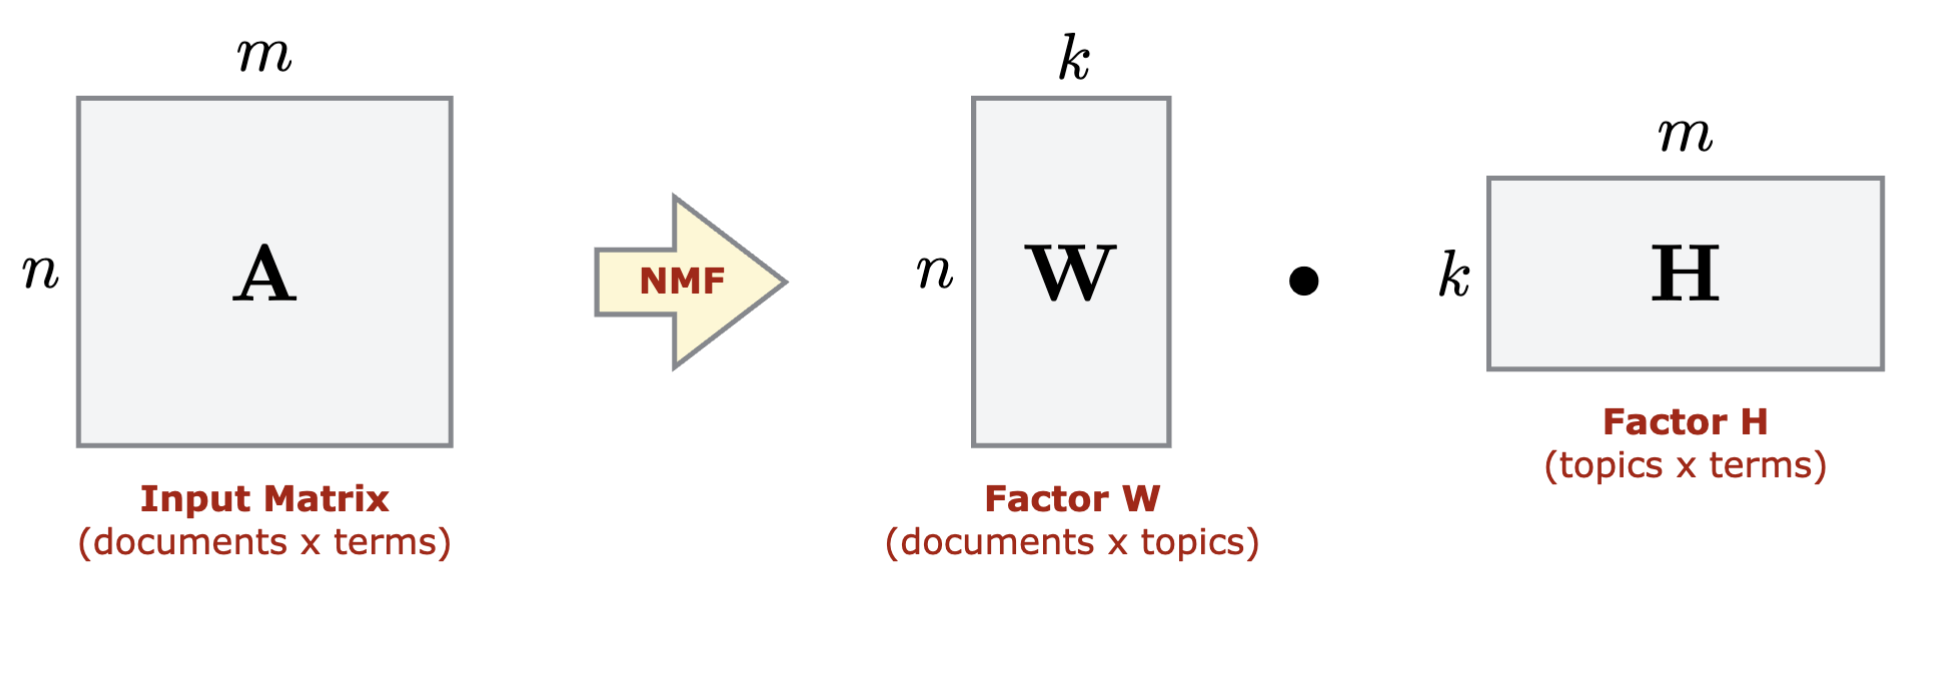

Some of the imports we'll need:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# This is the new one
from sklearn.decomposition import NMF
import matplotlib
import matplotlib.pyplot as plt

Here's a functions will let us display matrices nicely.

In [2]:
def display_matrix(mat, row_labels, col_labels, rows=10):
    return pd.DataFrame(mat, index=row_labels, columns=col_labels).head(rows).round(3)

def matrix_heatmap(mtx, row_labels, col_labels, cmap='YlOrBr'):
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    x_tick_marks = np.arange(len(col_labels))
    y_tick_marks = np.arange(len(row_labels))
    plt.xticks(x_tick_marks, col_labels, fontsize=8, rotation=90)
    plt.yticks(y_tick_marks, row_labels, fontsize=8)
    plt.tick_params("x", top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.imshow(mtx, norm=matplotlib.colors.LogNorm(), interpolation='nearest', cmap=cmap)

We will start with some toy texts to see how this works

In [ ]:
corpus = [
    'The sky is blue and beautiful.', 'Love this blue and beautiful sky!',
    'The quick brown fox jumps over the lazy dog.',
    "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
    'I love green eggs, ham, sausages and bacon!',
    'The brown fox is quick and the blue dog is lazy!',
    'The sky is very blue and the sky is very beautiful today',
    'The dog is lazy but the brown fox is quick!'
]
labels = [
    'weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather',
    'animals'
]

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

Some parameters we might want to vary

In [4]:
stop_list_source = "nltk_english.txt"
vocabulary_size = 1000
n_topics = 3
norm = False
max_ngram = 1
# Vectorizer = TfidfVectorizer
Vectorizer = CountVectorizer

extra_stop_words = []

### Create the document x term matrix

We are also going to create a frequency distribution for use later

In [5]:
if stop_list_source == "english":
    stopwords = "english"
else:
    with open('lists/' + stop_list_source, 'r') as f:
        stopwords = f.read().splitlines()
    stopwords += extra_stop_words

# Create the vectorizer
vectorizer = Vectorizer(max_features=vocabulary_size, 
                        stop_words=stopwords, 
                        ngram_range=(1, max_ngram))



doc_term_matrix = vectorizer.fit_transform(corpus_df['Document'].values)
if norm:
    doc_term_matrix = normalize(X, norm='l2')
corpus_df["vector"] = [x for x in doc_term_matrix.toarray()]

word_counts = np.array(doc_term_matrix.sum(axis=0)).flatten()
feature_names = vectorizer.get_feature_names_out()
fdist = dict(zip(feature_names, word_counts))

In [ ]:
display_matrix(doc_term_matrix.toarray(), corpus_df['Document'], vectorizer.get_feature_names_out(), 5)

### Do the topic analysis

In [7]:
nmf_model = NMF(init="nndsvd", n_components=n_topics) 
doc_topic_matrix = nmf_model.fit_transform(doc_term_matrix)
topic_term_matrix = nmf_model.components_

### The topic_term_matrix

In [ ]:
display_matrix(topic_term_matrix, range(n_topics), vectorizer.get_feature_names_out(), 30)

#### Some functions that can make interpreting these topic_term matrices easier to examine

The function displays the top-weighted terms in each topic.

It also has a fancier ability that we'll get to later

In [ ]:
from IPython.display import display_html
import math

def display_side_by_side(dfs, round_to=3):
    html_str = ''
    for i, df in enumerate(dfs):
        df_html = df.round(round_to).to_html(index=False)
        html_str += f'<div style="display:inline-block; vertical-align:top; margin-right:10px"><h4>Topic {i}</h4>{df_html}</div>'
    display_html(html_str, raw=True)

def wprob(w, cfdist, total_words):
    return cfdist[w] / total_words

def relevance(w, ld, pwt, cfdist, total_words, use_log=True):
    import math
    if use_log and pwt == 0:
        return -99999
    if use_log:
        return ld * math.log(pwt) + (1 - ld) * math.log(pwt / wprob(w, cfdist, total_words))
    else:
        return ld * pwt + (1 - ld) * (pwt / wprob(w, cfdist, total_words))
    
def display_topics(model, vectorizer, fdist, lbda, n=10, use_log=True):
    total_words = sum(fdist.values())
    feature_names = vectorizer.get_feature_names_out()
    topic_rel_dfs = []
    for topic in model.components_:
        topic_sum = sum(topic)
        word_rel_dict = {}
        for idx, word in enumerate(feature_names):
            pwt = topic[idx] / topic_sum
            word_rel_dict[word] = relevance(word, lbda, pwt, fdist, total_words, use_log=use_log)

        df = pd.DataFrame(sorted(list(word_rel_dict.items()), key=lambda x: x[1], reverse=True)[:n], columns=["word", "relevance"])
        topic_rel_dfs.append(df)
    display_side_by_side(topic_rel_dfs)
    return topic_rel_dfs

topic_rel_dfs = display_topics(nmf_model, vectorizer, fdist, 1, 5, True)

topic_labels = []
for topic_df in topic_rel_dfs:
    words = topic_df["word"].tolist()[:2]
    label = words[0] + "-" + words[1]
    topic_labels.append(label)
topic_labels

### The doc_topic_matrix

In [ ]:
display_matrix(doc_topic_matrix, corpus_df['Document'], range(n_topics), 30)

In [ ]:
matrix_heatmap(doc_topic_matrix, corpus_df['Document'], topic_labels, cmap='YlOrBr')

## pyLDAvis

`pyLDAvis` is a library that can make exploring the topics a bit easier. You'll probably need to install it.

```python
import os
os.system("pip install pyLDAvis")
```

This is the incantation that produces the visualization

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
data = pyLDAvis.lda_model.prepare(nmf_model, doc_term_matrix, vectorizer)
pyLDAvis.display(data)

#### Relevance

Rather than displaying the terms in a topic strictly according to weighting, pyLDAvis uses a measure called "relevance." This takes into account how common a term is in the overall corpus.

The idea is that some terms might be very common in all of the topics. We would like to see which terms are more specific to a given topic.

The relevance measure takes a parameter $\lambda$, which can range from zero to one. If $\lambda=1$ then relevance is just the raw weight for the term in the topic.

The `display_topics` function I provided you with above takes a value for lambda (lbda) and can sort by and display relevance>